In [1]:
import duckdb
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px


# run utils.db_setup to set up duckdb database
conn = duckdb.connect('amazon.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

## Schema
![](https://relbench.stanford.edu/img/amazon-reviews.png)

## Tasks

### `rel-amazon-ltv`

Task is to predict the sum of prices of the products purchased and reviewed by a user in the next 2 years.

Filter: Consider only users who wrote a review in the past two years before timestamp.

Regression

Metric: MAE

In [18]:
%%sql train_df <<
from ltv_train;

In [19]:
train_df.head()

,timestamp,customer_id,ltv,count_
0,2008-01-03,72743,1238.05,99
1,2008-01-03,456465,30.48,2
2,2008-01-03,456471,21.48,2
3,2008-01-03,55643,150.62,9
4,2008-01-03,39427,448.19,30


In [34]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.customer_id.nunique():,} customers.')
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of customers (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='customer_id', keep='last')
    .groupby('timestamp').customer_id.nunique() / train_df.customer_id.nunique()
)
print()
print('Label Distribution:')
mean = train_df.ltv.mean()
std = train_df.ltv.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(train_df.ltv == 0).mean():.1%}')
print(f'Quantiles: \n{train_df.ltv.quantile(np.arange(0, 1.1, 0.1))}')

TRAIN

724,664 samples over 451,350 customers.

Temporal dist of samples:
timestamp
1998-01    0.001533
2000-01    0.016866
2002-01    0.050884
2004-01    0.059699
2006-01    0.093377
2008-01    0.168782
2010-01    0.242906
2012-01    0.365953
Name: proportion, dtype: float64

Temporal dist of customers (first appearance):
timestamp
1998-01-05    0.001021
2000-01-05    0.013072
2002-01-04    0.043585
2004-01-04    0.042342
2006-01-03    0.074578
2008-01-03    0.117434
2010-01-02    0.252008
2012-01-02    0.455959
Name: customer_id, dtype: float64

Label Distribution:
Mean (std): 50.0 ± 204.4
Prop zeros: 46.8%
Quantiles: 
0.0        0.00
0.1        0.00
0.2        0.00
0.3        0.00
0.4        0.00
0.5        7.83
0.6       15.99
0.7       28.61
0.8       49.21
0.9       99.76
1.0    33858.40
Name: ltv, dtype: float64


In [35]:
%%sql val_df <<
from ltv_val;

In [39]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.customer_id.nunique():,} customers.')
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of customers (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='customer_id', keep='last')
    .groupby('timestamp').customer_id.nunique() / val_df.customer_id.nunique()
)
print()
print(f'Customers in val seen in train: {len(set(val_df.customer_id) & set(train_df.customer_id)):,}')
print()
print('Label Distribution:')
mean = val_df.ltv.mean()
std = val_df.ltv.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(val_df.ltv == 0).mean():.1%}')
print(f'Quantiles: \n{val_df.ltv.quantile(np.arange(0, 1.1, 0.1))}')

VAL

834,248 samples over 834,248 customers.

Temporal dist of samples:
timestamp
2014-01    1.0
Name: proportion, dtype: float64

Temporal dist of customers (first appearance):
timestamp
2014-01-01    1.0
Name: customer_id, dtype: float64

Customers in val seen in train: 247,523

Label Distribution:
Mean (std): 73.0 ± 196.3
Prop zeros: 23.2%
Quantiles: 
0.0        0.00
0.1        0.00
0.2        0.00
0.3       11.64
0.4       19.95
0.5       30.03
0.6       42.96
0.7       60.45
0.8       88.97
0.9      155.06
1.0    26467.99
Name: ltv, dtype: float64


### `rel-amazon-churn`

Predict if the user will review a product in the next 2 years.

Filter: Consider only users who wrote a review in the past two years.

Classification

Metric: AP

In [41]:
%%sql train_df <<
from churn_train;

In [42]:
train_df.head()

,timestamp,customer_id,churn
0,2012-01-02,1271504,1
1,2012-01-02,1271507,1
2,2012-01-02,1271606,0
3,2012-01-02,1271641,0
4,2012-01-02,1271700,0


In [46]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.customer_id.nunique():,} users.')
print()
print('Label Distribution:')
print(train_df.churn.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='customer_id', keep='last')
    .groupby('timestamp').customer_id.nunique() / train_df.customer_id.nunique()
)

TRAIN

724,664 samples over 451,350 users.

Label Distribution:
churn
0    0.532338
1    0.467662
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
1998-01    0.001533
2000-01    0.016866
2002-01    0.050884
2004-01    0.059699
2006-01    0.093377
2008-01    0.168782
2010-01    0.242906
2012-01    0.365953
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
1998-01-05    0.001079
2000-01-05    0.013351
2002-01-04    0.041704
2004-01-04    0.044196
2006-01-03    0.078179
2008-01-03    0.176072
2010-01-02    0.193384
2012-01-02    0.452035
Name: customer_id, dtype: float64


In [44]:
%%sql val_df <<
from churn_val;

In [47]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.customer_id.nunique():,} users.')
print()
print('Label Distribution:')
print(val_df.churn.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'Customers in val seen in train: {len(set(val_df.customer_id) & set(train_df.customer_id)):,}')
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='customer_id', keep='last')
    .groupby('timestamp').customer_id.nunique() / val_df.customer_id.nunique()
)

VAL

834,248 samples over 834,248 users.

Label Distribution:
churn
0    0.768315
1    0.231685
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2014-01    1.0
Name: proportion, dtype: float64

Customers in val seen in train: 247,523

Temporal dist of users (first appearance):
timestamp
2014-01-01    1.0
Name: customer_id, dtype: float64


### `rel-amazon-product-ltv`

Task is to predict TODO

Filter: TODO

Regression

Metric: MAE

In [49]:
%%sql train_df <<
from product_ltv_train;

In [50]:
train_df.head()

,timestamp,product_id,ltv,count_
0,2008-01-03,24818,138.50,10
1,2008-01-03,278751,63.98,2
2,2008-01-03,141304,44.73,9
3,2008-01-03,74608,17.34,2
4,2008-01-03,37868,44.40,6


In [51]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.product_id.nunique():,} products.')
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of products (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='product_id', keep='last')
    .groupby('timestamp').product_id.nunique() / train_df.product_id.nunique()
)
print()
print('Label Distribution:')
mean = train_df.ltv.mean()
std = train_df.ltv.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(train_df.ltv == 0).mean():.1%}')
print(f'Quantiles: \n{train_df.ltv.quantile(np.arange(0, 1.1, 0.1))}')

TRAIN

843,032 samples over 325,820 products.

Temporal dist of samples:
timestamp
1998-01    0.017386
2000-01    0.051301
2002-01    0.059221
2004-01    0.079623
2006-01    0.114316
2008-01    0.149961
2010-01    0.197219
2012-01    0.330973
Name: proportion, dtype: float64

Temporal dist of products (first appearance):
timestamp
1998-01-05    0.012237
2000-01-05    0.018010
2002-01-04    0.040384
2004-01-04    0.062973
2006-01-03    0.083921
2008-01-03    0.108078
2010-01-02    0.197677
2012-01-02    0.476720
Name: product_id, dtype: float64

Label Distribution:
Mean (std): 118.2 ± 1,328.7
Prop zeros: 0.0%
Quantiles: 
0.0         0.00
0.1         8.10
0.2        13.22
0.3        17.66
0.4        23.97
0.5        31.96
0.6        43.98
0.7        62.28
0.8        97.65
0.9       193.62
1.0    696262.25
Name: ltv, dtype: float64


In [52]:
%%sql val_df <<
from product_ltv_val;

In [55]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.product_id.nunique():,} products.')
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of products (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='product_id', keep='last')
    .groupby('timestamp').product_id.nunique() / val_df.product_id.nunique()
)
print()
print(f'Products in val seen in train: {len(set(val_df.product_id) & set(train_df.product_id)):,}')
print()
print('Label Distribution:')
mean = val_df.ltv.mean()
std = val_df.ltv.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(val_df.ltv == 0).mean():.1%}')
print(f'Quantiles: \n{val_df.ltv.quantile(np.arange(0, 1.1, 0.1))}')

VAL

380,181 samples over 380,181 products.

Temporal dist of samples:
timestamp
2014-01    1.0
Name: proportion, dtype: float64

Temporal dist of products (first appearance):
timestamp
2014-01-01    1.0
Name: product_id, dtype: float64

Products in val seen in train: 286,507

Label Distribution:
Mean (std): 300.7 ± 2,964.6
Prop zeros: 0.0%
Quantiles: 
0.0         0.00
0.1        13.81
0.2        23.10
0.3        34.74
0.4        49.11
0.5        68.85
0.6        96.00
0.7       142.12
0.8       233.64
0.9       494.55
1.0    842088.85
Name: ltv, dtype: float64


### `rel-amazon-product-churn`

TODO

Filter: TODO

Classification

Metric: AP

In [57]:
%%sql train_df <<
from product_churn_train;

In [58]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.product_id.nunique():,} users.')
print()
print('Label Distribution:')
print(train_df.churn.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='product_id', keep='last')
    .groupby('timestamp').product_id.nunique() / train_df.product_id.nunique()
)

TRAIN

565,756 samples over 233,716 users.

Label Distribution:
churn
0    0.727559
1    0.272441
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
1998-01    0.003084
2000-01    0.025907
2002-01    0.076443
2004-01    0.088245
2006-01    0.118647
2008-01    0.170342
2010-01    0.223457
2012-01    0.293876
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
1998-01-05    0.001378
2000-01-05    0.019002
2002-01-04    0.057078
2004-01-04    0.058212
2006-01-03    0.102548
2008-01-03    0.184951
2010-01-02    0.144107
2012-01-02    0.432726
Name: product_id, dtype: float64


In [59]:
%%sql val_df <<
from product_churn_val;

In [60]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.product_id.nunique():,} users.')
print()
print('Label Distribution:')
print(val_df.churn.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'Products in val seen in train: {len(set(val_df.product_id) & set(train_df.product_id)):,}')
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='product_id', keep='last')
    .groupby('timestamp').product_id.nunique() / val_df.product_id.nunique()
)

VAL

279,021 samples over 279,021 users.

Label Distribution:
churn
0    0.906749
1    0.093251
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2014-01    1.0
Name: proportion, dtype: float64

Products in val seen in train: 186,911

Temporal dist of users (first appearance):
timestamp
2014-01-01    1.0
Name: product_id, dtype: float64


## Customer

In [61]:
%%sql customer << 
from customer;

In [62]:
customer.head()

,customer_id,customer_name
0,0,TW Ervin II
1,1,Amazon Customer
2,2,Tekla Borner
3,3,Deborah K Woroniecki
4,4,E


In [63]:
customer['name_len'] = customer.customer_name.str.len()

In [64]:
customer.name_len.quantile(np.arange(0, 1.1, 0.1))

0.0      1.0
0.1      5.0
0.2      6.0
0.3      8.0
0.4      9.0
0.5     11.0
0.6     12.0
0.7     14.0
0.8     15.0
0.9     16.0
1.0    332.0
Name: name_len, dtype: float64

In [70]:
customer[customer.name_len > 50]

,customer_id,customer_name,name_len
345,345,Anne P. Rawson I&#039;m buying one for a frie...,66.0
1662,1662,"Jennifer Tzivia MacLeod, author of the Seven D...",98.0
1700,1700,Ariella Vaccarino creator of Voice Lessons To...,61.0
2213,2213,Ed Benjamin. Fiction and Nonfiction Author. Au...,83.0
2360,2360,"K.M. Weiland, Author of Historical and Specula...",58.0
...,...,...,...
1841247,1841247,"Richard W. Jennings, Senior Poet Laureate, Sta...",58.0
1842184,1842184,"Rick Scruggs, retired field grade officer, CGS...",56.0
1842582,1842582,reach herb huff BH hutch my wiki and join this...,100.0
1845273,1845273,"Donald Liponi, author of La Rumorosa Rock Art...",72.0


## Product

In [72]:
%%sql product <<
from product;

In [73]:
product.head()

,product_id,category,brand,title,description,price
0,0,"[Books, Literature & Fiction, Dramas & Plays]",Visit Amazon's William Shakespeare Page,Love's Labour's Lost: Performed by Derek Jacob...,William Shakespeare is widely regarded as the ...,20.93
1,1,"[Books, Children's Books, Literature & Fiction]",Louis (ed) UNTERMEYER,The golden treasury of poetry,Collection of Poetry,23.98
2,2,"[Books, Mystery, Thriller & Suspense]",Visit Amazon's Agatha Christie Page,The Blue Geranium (Miss Marple),None,8.82
3,3,"[Books, Humor & Entertainment]",Visit Amazon's Tom Baker Page,Who on Earth Is Tom Baker?,Tom Baker's autobiography covers his childhood...,159.95
4,4,"[Books, Christian Books & Bibles, Bible Study ...",Visit Amazon's Clarence Larkin Page,The Greatest Book on &quot;Dispensational Trut...,The Greatest Book on Dispensational Truth in t...,44.76


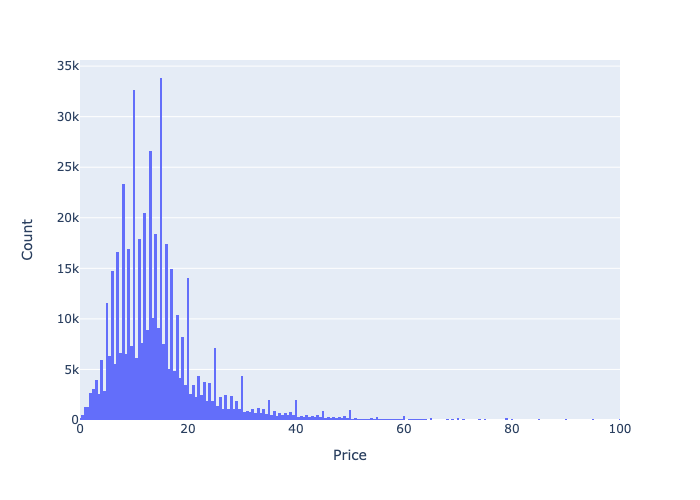

In [78]:
fig = px.histogram(x=product.price, range_x=(0, 100))
fig.update_layout(width=700, height=500, xaxis_title='Price', yaxis_title='Count')
fig.show(renderer='png')

In [98]:
product.category.iloc[0]

array(['Books', 'Literature & Fiction', 'Dramas & Plays'], dtype=object)

In [123]:
def get_specific(x):
    if isinstance(x, float):
        return ' '
    return str(x[-1])

cats = product.category.apply(get_specific)

In [124]:
cats.value_counts()

category
Genre Fiction                           35906
Literature &amp; Fiction                23231
                                        18854
Mystery                                 16530
Contemporary                            16437
                                        ...  
Environmentalists &amp; Naturalists         1
Foreign &amp; International Law             1
Birdwatching                                1
Ethics & Professional Responsibility        1
Coffee & Tea                                1
Name: count, Length: 671, dtype: int64

In [125]:
product['desc_len'] = product.description.str.len()
product['title_len'] = product.title.str.len()

In [127]:
product.desc_len.quantile(np.arange(0, 1.1, 0.1))

0.0        0.0
0.1        0.0
0.2        0.0
0.3        0.0
0.4      172.0
0.5      339.0
0.6      511.0
0.7      772.0
0.8     1106.0
0.9     1511.0
1.0    66180.0
Name: desc_len, dtype: float64

In [128]:
product.title_len.quantile(np.arange(0, 1.1, 0.1))

0.0      1.0
0.1     15.0
0.2     21.0
0.3     29.0
0.4     36.0
0.5     43.0
0.6     51.0
0.7     60.0
0.8     72.0
0.9     90.0
1.0    497.0
Name: title_len, dtype: float64

## Review

In [129]:
%%sql review <<
-- review is a large table beware of memory usage
from review;

In [130]:
review.head()

,review_time,customer_id,product_id,rating,verified,review_text,summary
0,2005-03-30,0,14,5.0,False,"The King, the Mice and the Cheese by Nancy Gur...",A story children will love and learn from
1,2015-07-09,3,14,5.0,False,LOVE IT,Five Stars
2,2015-01-18,4,14,5.0,True,Great!,Five Stars
3,2013-11-03,5,14,5.0,False,Over and over the king has problems. Fortunat...,Not Nice Mice
4,2013-10-08,6,14,5.0,True,I remember reading my parents' copy of this bo...,One of my favorite kids' stories


In [131]:
review.verified.value_counts()

verified
True     9106326
False    4611426
Name: count, dtype: int64

In [132]:
review.groupby('verified').rating.mean()

verified
False    4.183531
True     4.400643
Name: rating, dtype: float32

In [4]:
%%sql per_product <<
select
    product_id,
    avg(rating) as avg_rating,
    count(*) as num_reviews
from review
group by product_id

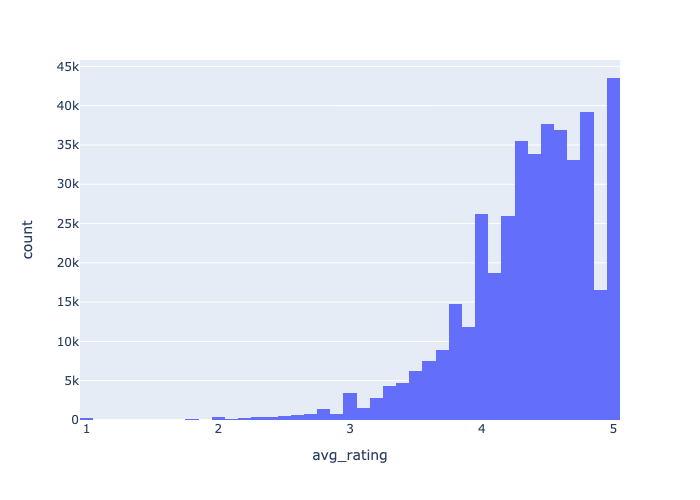

In [8]:
fig = px.histogram(per_product, x='avg_rating', nbins=50)
fig.update_layout(width=700, height=500)
fig.show(renderer='png')

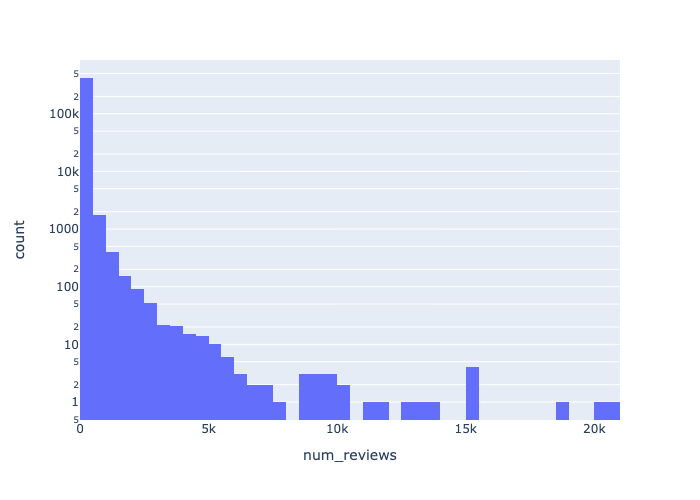

In [14]:
fig = px.histogram(per_product, x='num_reviews', nbins=50, log_y=True)
fig.update_layout(width=700, height=500)
fig.show(renderer='png')

In [16]:
%%sql per_customer <<
select
    customer_id,
    avg(rating) as avg_rating,
    count(*) as num_reviews
from review
group by customer_id

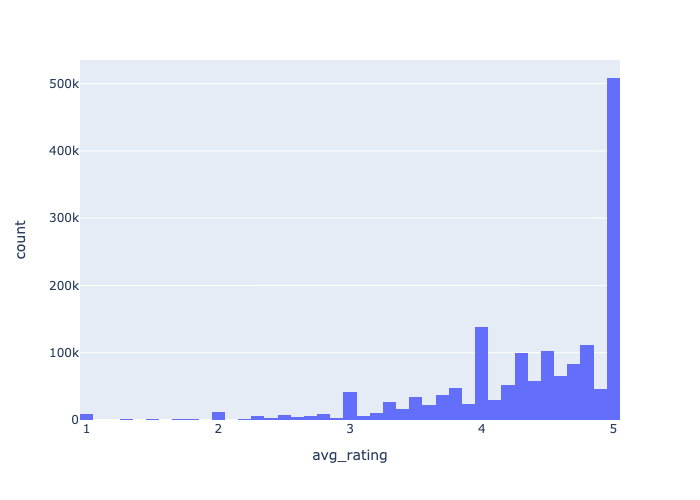

In [17]:
fig = px.histogram(per_customer, x='avg_rating', nbins=50)
fig.update_layout(width=700, height=500)
fig.show(renderer='png')

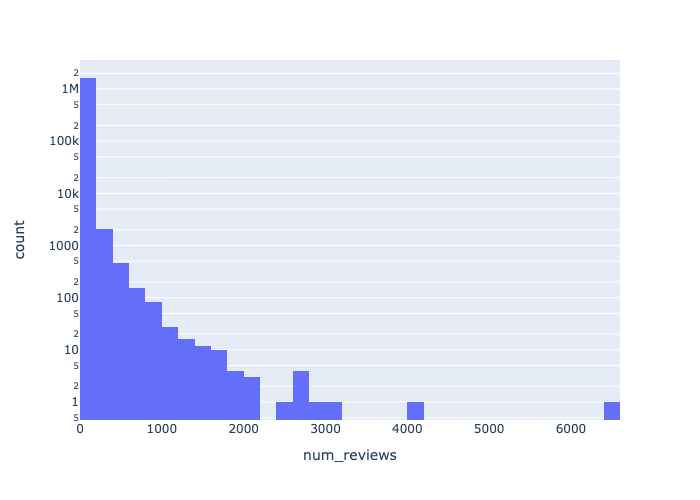

In [18]:
fig = px.histogram(per_customer, x='num_reviews', nbins=50, log_y=True)
fig.update_layout(width=700, height=500)
fig.show(renderer='png')

In [4]:
%%sql weeks_bw_reviews <<
select
    date_diff(
        'weeks',
        review_time,
        lead(review_time, 1) over (partition by customer_id order by review_time)
    ) as weeks_bw_reviews
from review

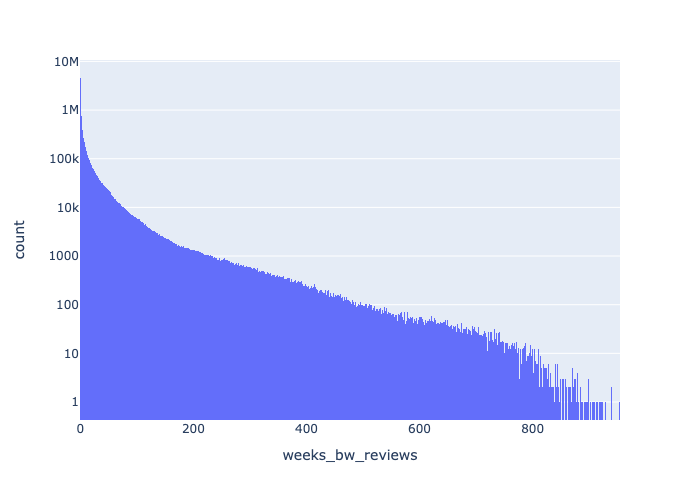

In [8]:
fig = px.histogram(weeks_bw_reviews, x='weeks_bw_reviews', log_y=True)
fig.update_layout(width=700, height=500)
fig.show(renderer='png')

In [9]:
weeks_bw_reviews.weeks_bw_reviews.quantile(np.arange(0, 1.1, 0.1))

0.0      0.0
0.1      0.0
0.2      0.0
0.3      0.0
0.4      1.0
0.5      2.0
0.6      4.0
0.7      8.0
0.8     17.0
0.9     42.0
1.0    954.0
Name: weeks_bw_reviews, dtype: float64

In [10]:
weeks_bw_reviews.weeks_bw_reviews.isna().mean()

0.11856082541804226